<a href="https://colab.research.google.com/github/feroj21/AAI/blob/main/Route_Optimization_Ant_Colony_and_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import io
import copy
import pickle
import datetime
import random
import matplotlib.pyplot as plt
import xgboost as xgb
from google.colab import drive

In [20]:
class Graph(object):
    def __init__(self, cost_matrix: list, rank: int):
        self.matrix = cost_matrix
        self.rank = rank
        self.pheromone = [[1 / (rank * rank)
                           for j in range(rank)] for i in range(rank)]


class ACO(object):
    def __init__(self, ant_count: int, generations: int):
        self.Q = 10.0
        self.rho = .7
        self.beta = 10
        self.alpha = 1
        self.ant_count = ant_count
        self.generations = generations
        self.update_strategy = 2

    def _update_pheromone(self, graph: Graph, ants: list):
        for i, row in enumerate(graph.pheromone):
            for j, col in enumerate(row):
                graph.pheromone[i][j] *= self.rho
                for ant in ants:
                    graph.pheromone[i][j] += ant.pheromone_delta[i][j]

    # noinspection PyProtectedMember
    def solve(self, graph: Graph):
        
        best_cost = float('inf')
        best_solution = []
        avg_costs = []
        best_costs = []
        for gen in range(self.generations):
            # noinspection PyUnusedLocal
            ants = [_Ant(self, graph) for i in range(self.ant_count)]
            for ant in ants:
                curr_cost = []
                for i in range(graph.rank - 1):
                    ant._select_next()
                ant.total_cost += graph.matrix[ant.tabu[-1]][ant.tabu[0]]
                curr_cost.append(ant.total_cost)
                if ant.total_cost < best_cost:
                    best_cost = ant.total_cost
                    best_solution = [] + ant.tabu
                # update pheromone
                ant._update_pheromone_delta()
            self._update_pheromone(graph, ants)
            best_costs.append(best_cost)
            avg_costs.append(np.mean(curr_cost))

            # print('Generation #{} best cost: {}, avg cost: {}, path: {}'.format(
            #         gen+1, best_cost, avg_costs[-1], best_solution))
                
        return best_solution, best_cost, avg_costs, best_costs


class _Ant(object):
    def __init__(self, aco: ACO, graph: Graph):
        self.colony = aco
        self.graph = graph
        self.total_cost = 0.0
        self.tabu = []  # tabu list
        self.pheromone_delta = []  # the local increase of pheromone
        # nodes which are allowed for the next selection
        self.allowed = [i for i in range(graph.rank)]
        self.eta = [[0 if i == j else 1 / graph.matrix[i][j] for j in range(graph.rank)] for i in
                    range(graph.rank)]  # heuristic information
        start = random.randint(0, graph.rank - 1)  # start from any node
        self.tabu.append(start)
        self.current = start
        self.allowed.remove(start)

    def _select_next(self):
        denominator = 0
        for i in self.allowed:
            denominator += self.graph.pheromone[self.current][i] ** self.colony.alpha * self.eta[self.current][
                i] ** self.colony.beta
        # noinspection PyUnusedLocal
        # probabilities for moving to a node in the next step
        probabilities = [0 for i in range(self.graph.rank)]
        for i in range(self.graph.rank):
            try:
                self.allowed.index(i)  # test if allowed list contains i
                probabilities[i] = self.graph.pheromone[self.current][i] ** self.colony.alpha * \
                    self.eta[self.current][i] ** self.colony.beta / denominator
            except ValueError:
                pass  # do nothing
        # select next node by probability roulette
        selected = 0
        rand = random.random()
        for i, probability in enumerate(probabilities):
            rand -= probability
            if rand <= 0:
                selected = i
                break
        self.allowed.remove(selected)
        self.tabu.append(selected)
        self.total_cost += self.graph.matrix[self.current][selected]
        self.current = selected

    # noinspection PyUnusedLocal
    def _update_pheromone_delta(self):
        self.pheromone_delta = [
            [0 for j in range(self.graph.rank)] for i in range(self.graph.rank)]
        for _ in range(1, len(self.tabu)):
            i = self.tabu[_ - 1]
            j = self.tabu[_]
            if self.colony.update_strategy == 1:  # ant-quality system
                self.pheromone_delta[i][j] = self.colony.Q
            elif self.colony.update_strategy == 2:  # ant-density system
                # noinspection PyTypeChecker
                self.pheromone_delta[i][j] = self.colony.Q / \
                    self.graph.matrix[i][j]
            else:  # ant-cycle system
                self.pheromone_delta[i][j] = self.colony.Q / self.total_cost

#Variables declaration

Cost Matrix Generate [Based on time between point]

In [4]:
def generate_cost_matrix(rank):
  cost_matrix = []
  for i in range(rank):
      row = []
      for j in range(rank):
          row.append(time_cost_between_points(locations[i], locations[j]))
      cost_matrix.append(row)

  return cost_matrix

In [6]:
def trip_distance_cost(loc1, loc2):
    return 0.621371 * 6371 * (
        abs(2 * np.arctan2(np.sqrt(np.square(
            np.sin((abs(loc2['y'] - loc1['y']) * np.pi / 180) / 2))),
            np.sqrt(1-(np.square(np.sin((abs(loc2['y'] - loc1['y']) * np.pi / 180) / 2)))))) +
        abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(loc2['x'] - loc1['x']) * np.pi / 180) / 2))),
                           np.sqrt(1-(np.square(np.sin((abs(loc2['x'] - loc1['x']) * np.pi / 180) / 2)))))))

In [7]:
def time_cost_between_points(loc1, loc2):
    date_list = [10, 10, 2020]

    year = int(date_list[2])
    month = int(date_list[1])
    day = int(date_list[0])

    my_date = datetime.date(year, month, day)

    model_data = {'passenger_count': 1,
                  'pickup_longitude': loc1['x'],
                  'pickup_latitude': loc1['y'],
                  'dropoff_longitude': loc2['x'],
                  'dropoff_latitude': loc2['y'],
                  'store_and_fwd_flag': False,
                  'pickup_month': my_date.month,
                  'pickup_day': my_date.day,
                  'pickup_weekday': my_date.weekday(),
                  'pickup_hour': 23,
                  'pickup_minute': 10,
                  'latitude_difference': loc2['y'] - loc1['y'],
                  'longitude_difference': loc2['x'] - loc1['x'],
                  'trip_distance': trip_distance_cost(loc1, loc2)
                  }

    df = pd.DataFrame([model_data], columns=model_data.keys())
    pred = np.exp(loaded_model.predict(xgb.DMatrix(df))) - 1
    return pred[0]

In [8]:
def total_cost_from_path(path):
    total_cost = 0
    for i in range(1, len(path)):
        j = i - 1
        total_cost += cost_matrix[path[j]][path[i]]
    # Find time it takes to go back to original location
    total_cost += cost_matrix[path[-1]][path[0]]
    return total_cost

#Training model and variables

In [10]:
location_count = 15

locations = []
points = []
drive.mount('/content/gdrive')

#Model Training
filename = "gdrive/My Drive/ANT/xgb_model.sav"
loaded_model = pickle.load(open(filename, 'rb'))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[09:07:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [11]:
df = pd.read_csv('gdrive/My Drive/ANT/test.csv')[:location_count]
for index, row in df.iterrows():
    locations.append({
        'index': index,
        'x': row['pickup_longitude'],
        'y': row['pickup_latitude']
    })
    points.append((row['pickup_longitude'], row['pickup_latitude']))


#ACO Algorithms

126.95769550275803


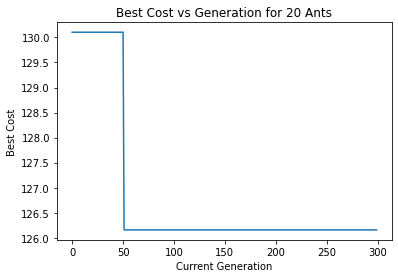

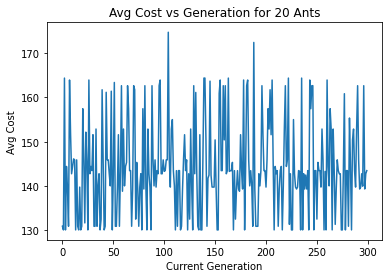

In [39]:
rank = len(locations)
g = 300
a = 20
cost_matrix = generate_cost_matrix(rank)

# Pass in user arguments
aco = ACO(ant_count=a, generations=g)

# Build graph with cost matrix and number of points
graph = Graph(cost_matrix, rank)
# Get results from ant colony, specify whether verbose output
result = []
for i in range(5):
  best_path, cost, avg_costs, best_costs = aco.solve(graph)
  result.append(best_costs)

x_values = [i for i in range(g)]
plt.title("Best Cost vs Generation for " + str(a) + " Ants")
plt.ylabel("Best Cost")
plt.xlabel("Current Generation")
plt.plot(x_values, best_costs)
plt.show()

#Genetic Algorithms

In [140]:
def GA(generations, p):
  best_cost = 0
  best_path = []
  y_values = []
  for g in range(generations):
    # Store the generation's best costs
    g_star = []
    # Iterate through each path in population
    for i in range(p):
        # Mutation
        # Select a random path, not including current
        indicies = [j for j in range(p)]
        indicies.remove(i)
        mutant_index = int(random.sample(indicies, 1)[0])
        mutant_candidate = population[mutant_index]

        # Swap indicies based on mutation rate
        mutated_path = []
        for d in range(loc_count):
            if random.random() <= mutation and d > 0:
                mutated_path.append(mutated_path[d-1])
                mutated_path[d-1] = mutant_candidate[d]
            else:
                mutated_path.append(mutant_candidate[d])

        # Crossover
        # Create candidate path by crossing over with mutant
        curr_element = population[i]
        candidate = []
        for d in range(loc_count):
            # Roll for chance to crossover value
            if random.random() <= crossover:
                candidate.append(mutated_path[d])
            else:
                candidate.append(curr_element[d])

        # Remove duplicate indicies
        candidate = list(dict.fromkeys(candidate))
        # Find missing indicies
        missing_indicies = []
        for d in range(loc_count):
            if d not in candidate:
                missing_indicies.append(d)

        # Merge candidate with shuffled missing indicies
        random.shuffle(missing_indicies)
        candidate += missing_indicies

        # Selection
        # Select parent based on smaller path cost
        candidate_cost = total_cost_from_path(candidate)
        curr_cost = total_cost_from_path(curr_element)

        if candidate_cost < curr_cost:
            population[i] = copy.copy(candidate)
            g_star.append(candidate_cost)
        else:
            g_star.append(curr_cost)

    best_cost = min(g_star)
    y_values.append(best_cost)
    avg_costs.append(np.mean(g_star))
    best_path = population[g_star.index(best_cost)]
  return best_cost, best_path, y_values


In [145]:

mutation = .5  
crossover = .7
loc_count = 15
population = []
n = 20
for i in range(n):
    new_path = [j for j in range(loc_count)]
    random.shuffle(new_path)
    population.append(new_path)
# For plotting
x_values = [i for i in range(generations)]
avg_costs = []

In [154]:

generations = 300
result = []
b_path = []
y_values_u = []

# for i in range(5):
#   b_cost, b_path, y_values_u = GA(generations, n)
#   result.append(b_cost)
b_cost, b_path, y_values = GA(generations, n)
# print(np.mean(result))
print(y_values)
print(b_cost)

[131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287, 131.43754482269287,

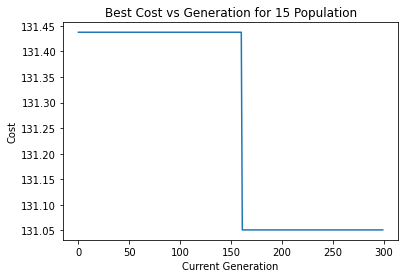

In [157]:
# Plot out the results
plt.title("Best Cost vs Generation for " + str(n) + " Population")
plt.ylabel("Cost")
plt.xlabel("Current Generation")
plt.plot(x_values, y_values)
plt.show()


Reference for CSP in routing: 
 1. https://www.researchgate.net/publication/236455098_A_constraint_programming-based_library_for_the_Vehicle_Routing_Problem
 2. https://stackoverflow.com/questions/49741213/tsp-optimization-csp-algorithm